## Similarity Scoring Demo

In [42]:
import avn.similarity as similarity
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pip install https://github.com/gasteigerjo/pyemd/archive/refs/heads/python3.zip

Zebra finch song is learned by imitating the song of an adult tutor. We can measure pupil bird's song learning success by comparing its song to its tutor's song, with higher similarity indicating better learning. 

AVN's similarity scoring module works by calculating 8-dimensional representations (or *embeddings*) of syllables from different birds, then calculating the distance between the two birds' syllable distributions. The embeddings are generated by feeding spectrograms of segmented syllables to a trained neural network that embeds similar syllables close together and dissimilar syllables far apart. We've shown that this model generalizes to zebra finches across multiple colonies and recording setups, so there should be no need for you to retrain the model. Just feed it your spectrograms and get scoring! 

The more syllables from each bird, the more reliable the scores you will obtain. Generally, we recommend at least 1000 total syllables from each bird (about 100 bouts), but more is better.

## Prepare Spectrograms 

Before we can calculate the embedding coordinates, we need to generate spectrograms of each segmented syllable in a way that is compatible with our embedding model. This is done by calling the function `similarity.prep_spects(Bird_ID, segmentations, song_folder_path, out_dir)`, where: 
- `Bird_ID` is the ID of the subject bird, 
- `segmentations` is a pandas dataframe of syllable segmentations, with one row per syllable, and columns called :
    - 'files' : the name of the .wav file in which a syllable is found, 
    - 'onsets' : the onset of the syllable within the .wav file in seconds, and 
    - 'offsets': the offset of the syllable within the .wav file in seconds. 
    
    We recommend using [WhisperSeg](https://github.com/nianlonggu/WhisperSeg) to automatically segment song syllables and generate this type of table.
- `song_folder_path` is the path to the folder containing all the wav files from `segmentations`. 
- `out_dir` is the path to the folder where you want the generated spectrograms to be saved.  

In [59]:
Bird_ID = 'G402'
segmentations = pd.read_csv('../sample_data/G402_syll_df.csv')
segmentations.head()

,files,onsets,offsets,labels
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i
3,G402_43362.23322048_9_19_6_28_42.wav,0.690363,0.751837,i
4,G402_43362.23322048_9_19_6_28_42.wav,0.828390,0.898912,i


*This bird's segmentation table also has syllable labels, but these aren't necessary and won't impact the embeddings or similarity scores.* 

In [60]:
song_folder_path = '../sample_data/G402/'
out_dir = '../sample_data/G402_embedding_spectrograms/'

In [61]:
similarity.prep_spects(Bird_ID=Bird_ID, segmentations=segmentations, song_folder_path=song_folder_path, out_dir=out_dir)

594 syllable spectrograms saved in ../sample_data/G402_embedding_spectrograms/


## Calculate Embeddings

Now that we have spectrograms for all our syllables, we need to load the embedding model and use it to generate embeddings of our syllables. You can load the model by calling `similarity.load_model()`. This function will check if your device has a cuda GPU, and if it does it will prepare the model to run on the GPU. Otherwise it will run on CPU. If you want to override this and have it run on CPU regardless of GPU availability, you can specify the parameter `device = 'cpu'`.

In [62]:
model = similarity.load_model()

Device set to: cuda


Now that we have the model, we can calculate the embeddings of all the syllables that we prepared before by running `similarity.calc_embeddings()`. This function takes the following parameters as input: 
- `Bird_ID`: The ID of the bird to be processed, 
- `spectrograms_dir` : The path to the directory where you saved the prepared spectrograms, 
- `model`: The model object that you just loaded with `similarity.load_model()`

In [36]:
embeddings_G402 = similarity.calc_embeddings(Bird_ID = 'G402', 
                                             spectrograms_dir='../sample_data/G402_embedding_spectrograms/', 
                                             model = model)
embeddings_G402.shape

(594, 8)

This created a matrix with one row per syllable and one column per dimension in the embedding space. Let's take a peak at the distribution by plotting the syllables with respect to the first two principal components of the embedding space: 

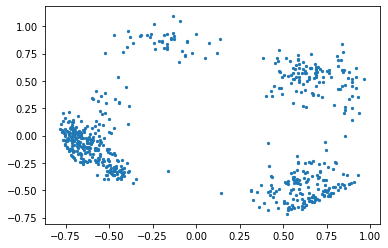

In [37]:
pca = PCA(n_components=2)
embeddings_PCs = pca.fit_transform(embeddings_G402)
plt.scatter(embeddings_PCs[:, 0], embeddings_PCs[:, 1], s = 5)

As you can see, the points seem to be forming four major clusters, which roughly correspond to different syllable types in the bird's song. These clusters would be denser and more obvious if we included more renditions in the embedding, but we've kept this example dataset small for the sake of speed and memory. Normally, we would recommend including at least 100 song bouts in a bird's embedding to get the most reliable EMD dissimilarity scores.  

## Compare song sets with EMD

First, we need to calculate the embeddings of a different bird to compare G402 against. 

In [38]:
Bird_ID = 'R402'
segmentations = pd.read_csv('../sample_data/R402_syll_df.csv')
song_folder_path = '../sample_data/R402/'
out_dir = '../sample_data/R402_embedding_spectrograms/'

similarity.prep_spects(Bird_ID=Bird_ID, segmentations=segmentations, song_folder_path=song_folder_path, out_dir=out_dir)

embeddings_R402 = similarity.calc_embeddings(Bird_ID = 'R402', spectrograms_dir='../sample_data/R402_embedding_spectrograms/', 
                                        model = model)

709 syllable spectrograms saved in ../sample_data/R402_embedding_spectrograms/


Let's see how similar these distributions are with PCA: 

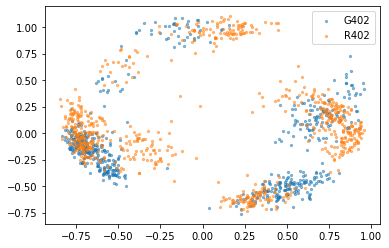

In [51]:
pca = PCA(n_components=2)
pca.fit(np.concatenate((embeddings_G402, embeddings_R402)))
embedding_PCs_R402 = pca.transform(embeddings_R402)
embedding_PCs_G402 = pca.transform(embeddings_G402)
plt.scatter(embedding_PCs_G402[:, 0], embedding_PCs_G402[:, 1], s = 5, label = 'G402', alpha = 0.5)
plt.scatter(embedding_PCs_R402[:, 0], embedding_PCs_R402[:, 1], s = 5, label = 'R402', alpha = 0.5)
plt.legend()

From this plot you can see that birds R402 and G402's syllables have a good deal of overlap, which is to be expected as these two birds are siblings and share the same song tutor. Let's quantify how similar they are by calculating the Earth Mover's Distance (EMD) between their distributions. The EMD is a distance measure that is proportional to the amount of work required to move all points in one distribution so that they match the other. The minimum possible EMD score is 0 for identical distributions. Within the confines of our embedding space, the maximum possible score is 1.41. Typically, tutor-pupil pairs will have score around 0.65 and unrelated birds will have scores around 0.85. 

NOTE: Be sure to use the full 8-dimensional embeddings for this. The principal components are just to help us visualize the distributions. 

In [52]:
emd = similarity.calc_emd(embeddings_G402, embeddings_R402)
emd

0.5505038523210175

This is a pretty low EMD score! In line with what we would expect for a comparison between a pupil and a tutor, or for very similar siblings (which these are). Nevertheless, we'll see that two subsets of syllables from the same bird are still even more similar to each other, as indicated by an even lower EMD score. 

In [56]:
emd = similarity.calc_emd(embeddings_R402[:350], embeddings_R402[350:])
emd

0.2633677558620733

For a thorough validation of this similarity scoring method, and to understand the range of similarity scores we would expect for different types of comparisons and learning outcomes, please see our preprint: *Coming Soon!*